<a href="https://colab.research.google.com/github/ishitavasishth/YouTubePredictor/blob/main/YouTube_Video_View_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset downloaded at: /root/.cache/kagglehub/datasets/datasnaek/youtube/versions/24
Columns: ['video_id', 'title', 'channel_title', 'category_id', 'tags', 'views', 'likes', 'dislikes', 'comment_total', 'thumbnail_link', 'date']


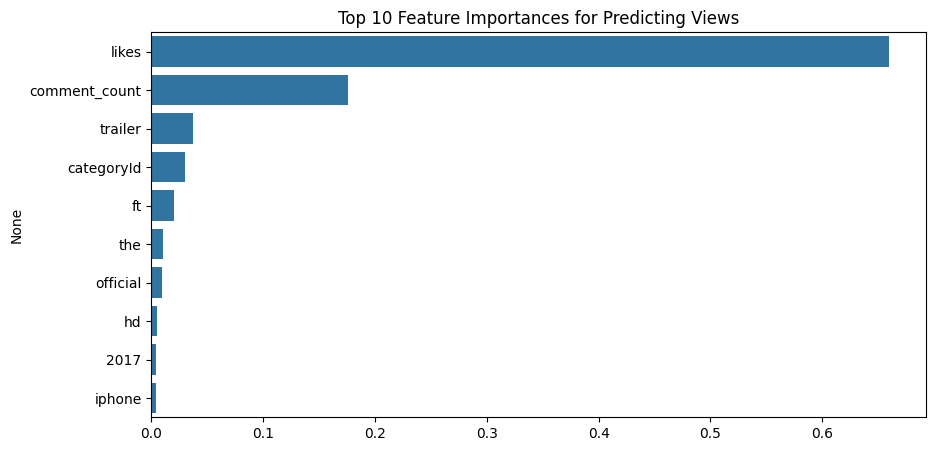

In [9]:
# 📌 STEP 1: Install necessary libraries
!pip install -q kagglehub ipywidgets transformers

# 📌 STEP 2: Load the dataset using KaggleHub (no uploads required)
import kagglehub
import os
import pandas as pd

# Download dataset and get path
path = kagglehub.dataset_download("datasnaek/youtube")
print("✅ Dataset downloaded at:", path)

# Load USvideos.csv with error handling
csv_path = os.path.join(path, "USvideos.csv")
df = pd.read_csv(csv_path, on_bad_lines='skip', encoding='latin1')

# Show available columns for reference
print("Columns:", df.columns.tolist())

# Rename columns to expected ones for consistency
df.rename(columns={
    'category_id': 'categoryId',
    'comment_total': 'comment_count',
    'date': 'publish_time'
}, inplace=True)

# Safely select existing relevant columns
required_cols = ['title', 'categoryId', 'publish_time', 'views', 'likes', 'comment_count']
df = df[[col for col in required_cols if col in df.columns]]
df.dropna(inplace=True)

if 'likes' in df.columns:
    df = df[df['likes'] > 0]  # Remove rows with 0 likes

# 📌 STEP 3: Feature Engineering
import datetime

if 'publish_time' in df.columns:
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
    df['publish_hour'] = df['publish_time'].dt.hour.fillna(0).astype(int)
else:
    df['publish_hour'] = 12  # fallback if missing

# Extract basic title features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50)
tfidf_title = vectorizer.fit_transform(df['title'].astype(str)).toarray()
tfidf_df = pd.DataFrame(tfidf_title, columns=vectorizer.get_feature_names_out())

# Combine features
features_base = ['likes', 'comment_count', 'categoryId', 'publish_hour']
df_model = pd.concat([df[['views'] + features_base].reset_index(drop=True), tfidf_df], axis=1)

# 📌 STEP 4: Build Regression Model to Predict Views
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X = df_model.drop('views', axis=1)
y = df_model['views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# 📌 STEP 5: Visualize Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Top 10 Feature Importances for Predicting Views")
plt.show()

# 📌 STEP 6: Build an Interactive UI for Testing
from ipywidgets import widgets, VBox, HBox
from IPython.display import display, clear_output

category_input = widgets.IntSlider(value=24, min=1, max=50, step=1, description='CategoryId:')
hour_input = widgets.IntSlider(value=12, min=0, max=23, step=1, description='Hour:')
title_input = widgets.Text(value='', placeholder='Enter video title', description='Title:')
output = widgets.Output()

predict_btn = widgets.Button(description='Predict Views 🎥', button_style='success')

# Title to TF-IDF feature vector
def title_to_features(title):
    title_vec = vectorizer.transform([title]).toarray()
    padded = [0] * 50
    for i, col in enumerate(vectorizer.get_feature_names_out()):
        if i < title_vec.shape[1]:
            padded[i] = title_vec[0][i]
    return padded

# Predict on new input
def predict_handler(b):
    with output:
        clear_output()
        title_feat = title_to_features(title_input.value)
        features = [0]*X.shape[1]
        features[0] = 0  # likes (dummy)
        features[1] = 0  # comment_count (dummy)
        features[2] = category_input.value
        features[3] = hour_input.value
        features[4:] = title_feat
        pred = model.predict([features])[0]
        print(f"📊 Predicted Views: {int(pred):,}")

predict_btn.on_click(predict_handler)
display(VBox([title_input, HBox([category_input, hour_input]), predict_btn, output]))

In [6]:
print(df.columns.tolist())


['video_id', 'title', 'channel_title', 'category_id', 'tags', 'views', 'likes', 'dislikes', 'comment_total', 'thumbnail_link', 'date']


In [10]:
# Grab 50 real video titles from the dataset
sample_titles = df['title'].dropna().unique().tolist()
sample_titles = sample_titles[:50]  # Limit to 50 for dropdown

# Create dropdown to select one, or type your own
dropdown_input = widgets.Dropdown(
    options=["(Pick a real title)"] + sample_titles,
    description='Sample:',
    layout=widgets.Layout(width='90%')
)

# Sync dropdown with manual input
def update_title_from_dropdown(change):
    if change['new'] != "(Pick a real title)":
        title_input.value = change['new']

dropdown_input.observe(update_title_from_dropdown, names='value')


In [11]:
display(VBox([
    dropdown_input,
    title_input,
    HBox([category_input, hour_input]),
    predict_btn,
    output
]))


✅ Dataset downloaded at: /root/.cache/kagglehub/datasets/datasnaek/youtube/versions/24
Columns: ['video_id', 'title', 'channel_title', 'category_id', 'tags', 'views', 'likes', 'dislikes', 'comment_total', 'thumbnail_link', 'date']


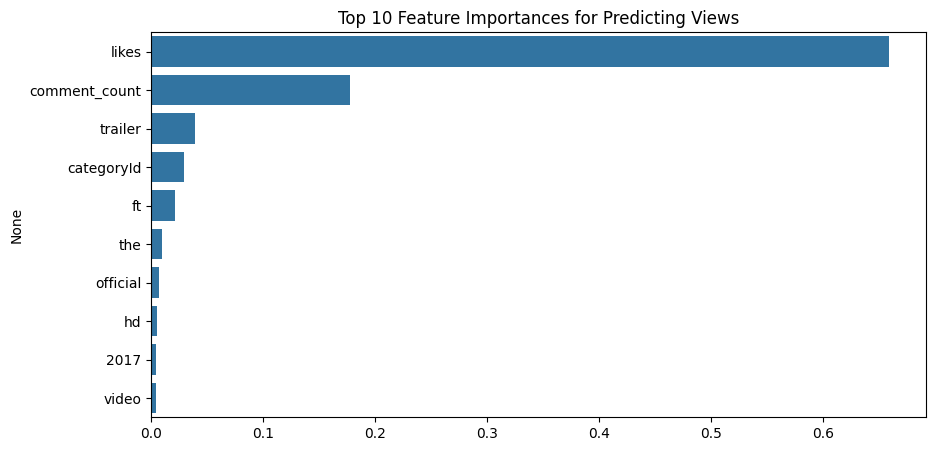

In [12]:
# 📌 STEP 1: Install necessary libraries
!pip install -q kagglehub ipywidgets transformers

# 📌 STEP 2: Load the dataset using KaggleHub (no uploads required)
import kagglehub
import os
import pandas as pd

# Download dataset and get path
path = kagglehub.dataset_download("datasnaek/youtube")
print("✅ Dataset downloaded at:", path)

# Load USvideos.csv with error handling
csv_path = os.path.join(path, "USvideos.csv")
df = pd.read_csv(csv_path, on_bad_lines='skip', encoding='latin1')

# Show available columns for reference
print("Columns:", df.columns.tolist())

# Rename columns to expected ones for consistency
df.rename(columns={
    'category_id': 'categoryId',
    'comment_total': 'comment_count',
    'date': 'publish_time'
}, inplace=True)

# Safely select existing relevant columns
required_cols = ['title', 'categoryId', 'publish_time', 'views', 'likes', 'comment_count']
df = df[[col for col in required_cols if col in df.columns]]
df.dropna(inplace=True)

if 'likes' in df.columns:
    df = df[df['likes'] > 0]  # Remove rows with 0 likes

# 📌 STEP 3: Feature Engineering
import datetime

if 'publish_time' in df.columns:
    df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
    df['publish_hour'] = df['publish_time'].dt.hour.fillna(0).astype(int)
else:
    df['publish_hour'] = 12  # fallback if missing

# Extract basic title features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50)
tfidf_title = vectorizer.fit_transform(df['title'].astype(str)).toarray()
tfidf_df = pd.DataFrame(tfidf_title, columns=vectorizer.get_feature_names_out())

# Combine features
features_base = ['likes', 'comment_count', 'categoryId', 'publish_hour']
df_model = pd.concat([df[['views'] + features_base].reset_index(drop=True), tfidf_df], axis=1)

# 📌 STEP 4: Build Regression Model to Predict Views
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

X = df_model.drop('views', axis=1)
y = df_model['views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# 📌 STEP 5: Visualize Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title("Top 10 Feature Importances for Predicting Views")
plt.show()

# 📌 STEP 6: Build an Interactive UI for Testing
from ipywidgets import widgets, VBox, HBox
from IPython.display import display, clear_output

category_input = widgets.IntSlider(value=24, min=1, max=50, step=1, description='CategoryId:')
hour_input = widgets.IntSlider(value=12, min=0, max=23, step=1, description='Hour:')
title_input = widgets.Text(value='', placeholder='Enter video title', description='Title:')
likes_input = widgets.IntSlider(value=1000, min=0, max=100000, step=100, description='Likes:')
comments_input = widgets.IntSlider(value=100, min=0, max=10000, step=10, description='Comments:')

# Dropdown for real titles
sample_titles = df['title'].dropna().unique().tolist()
sample_titles = sample_titles[:50]
dropdown_input = widgets.Dropdown(
    options=["(Pick a real title)"] + sample_titles,
    description='Sample:',
    layout=widgets.Layout(width='90%')
)

def update_title_from_dropdown(change):
    if change['new'] != "(Pick a real title)":
        title_input.value = change['new']

dropdown_input.observe(update_title_from_dropdown, names='value')

output = widgets.Output()
predict_btn = widgets.Button(description='Predict Views 🎥', button_style='success')

# Title to TF-IDF feature vector
def title_to_features(title):
    title_vec = vectorizer.transform([title]).toarray()
    padded = [0] * 50
    for i, col in enumerate(vectorizer.get_feature_names_out()):
        if i < title_vec.shape[1]:
            padded[i] = title_vec[0][i]
    return padded

# Predict on new input
def predict_handler(b):
    with output:
        clear_output()
        title_feat = title_to_features(title_input.value)
        features = [0]*X.shape[1]
        features[0] = likes_input.value
        features[1] = comments_input.value
        features[2] = category_input.value
        features[3] = hour_input.value
        features[4:] = title_feat
        pred = model.predict([features])[0]

        # Virality score from predicted views
        if pred < 1000:
            label = "❌ Low"
        elif pred < 100000:
            label = "⚠️ Medium"
        else:
            label = "🔥 High"

        print(f"📊 Predicted Views: {int(pred):,} → Virality: {label}")

predict_btn.on_click(predict_handler)
display(VBox([
    dropdown_input,
    title_input,
    category_input,
    hour_input,
    likes_input,
    comments_input,
    predict_btn,
    output
]))
